# MASSpy Tutorial

In this notebook example, a step-by-step approach of building a simple model$^1$ of trafficking of high-energy phosphate bonds is demonstrated. Illustrated below is a graphical view of the full system along with the reaction rate equations and numerical values:

![PhosTrafficking](./phosphate_trafficking.png)

## Creating a Model

In [1]:
import numpy as np
import pandas as pd

from mass import (
    MassConfiguration, MassMetabolite, MassModel, MassReaction)
from mass.util.matrix import left_nullspace, nullspace

mass_config = MassConfiguration()

The first step to creating the model is to define the `MassModel` object. A `MassModel` only requires an identifier to be initialized. For best practice, it is recommended to utilize SBML compliant identifiers for all objects.

In [2]:
model = MassModel("Phosphate_Trafficking")

Set parameter Username
Academic license - for non-commercial use only - expires 2022-01-21


The model is initially empty.

In [3]:
print("Number of metabolites: {0}".format(len(model.metabolites)))
print("Number of initial conditions: {0}".format(len(model.initial_conditions)))
print("Number of reactions: {0}".format(len(model.reactions)))

Number of metabolites: 0
Number of initial conditions: 0
Number of reactions: 0


The next step is to create `MassMetabolite` and `MassReaction` objects to represent the metabolites and reactions that should exist in the model.

### Defining metabolites

To create a `MassMetabolite`, a unique identifier is required. The `formula` and `charge` attributes are set to ensure mass and charge balancing of reactions in which the metabolite is a participant. The `compartment` attribute indicates where the metabolite is located. In this model, all metabolites exist in a single compartment, abbreviated as "c". 

In [4]:
atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")

adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c")

amp_c = MassMetabolite(
    "amp_c",
    name="AMP",
    formula="C10H12N5O7P",
    charge=-2,
    compartment="c")

The metabolite concentrations can be defined as the initial conditions for the metabolites using the `initial_condition` attribute. As previously stated, the concentrations are $\text{[ATP]}=1.6$, $\text{[ADP]}=0.4$, and $\text{[AMP]}=0.1$.

In [5]:
atp_c.initial_condition = 1.6
adp_c.ic = 0.4  # Alias for initial_condition
amp_c.ic = 0.1

for metabolite in [atp_c, adp_c, amp_c]:
    print("{0}: {1}".format(metabolite.id, metabolite.initial_condition))

atp_c: 1.6
adp_c: 0.4
amp_c: 0.1


The metabolites are currently not a part of any reaction. Consequently, the `ordinary_differential_equation` attribute is `None`. 

In [6]:
print(atp_c.ordinary_differential_equation)
print(adp_c.ode)  # Alias for ordinary_differential_equation
print(amp_c.ode)  

None
None
None


The next step is to create the reactions in which the metabolites participate.

### Defining reactions

Just like `MassMetabolite` objects, a unique identifier is also required to create a `MassReaction`. The `reversible` attribute determines whether the reaction can proceed in both the forward and reverse directions, or only in the forward direction. 

In [7]:
distr = MassReaction("distr", name="Distribution", reversible=True)
use = MassReaction("use", name="ATP Utilization", reversible=False)
form = MassReaction("form", name="ATP Formation", reversible=False)

Metabolites are added to reactions using a dictionary of metabolite objects and their stoichiometric coefficients. A group of metabolites can be added either all at once or one at a time. A negative coefficient indicates the metabolite is a reactant, while a positive coefficient indicates the metabolite is a product.

In [8]:
distr.add_metabolites({
    adp_c: -2,
    atp_c: 1,
    amp_c: 1})

use.add_metabolites({
    atp_c: -1,
    adp_c: 1})

form.add_metabolites({
    adp_c: -1,
    atp_c: 1})

for reaction in [distr, use, form]:
    print(reaction)

distr: 2 adp_c <=> amp_c + atp_c
use: atp_c --> adp_c
form: adp_c --> atp_c


Once the reactions are created, their parameters can be defined. As stated earlier, the distribution reaction is considerably faster when compared to other reactions in the model. The forward rate constant $k^{\rightarrow}$, represented as `kf`, can be set as $k^{\rightarrow}_{distr}=1000\ \text{min}^{-1}$. The equilibrium constant $K_{eq}$, represented as `Keq`, is approximately $K_{distr}=1$.

In [9]:
distr.forward_rate_constant = 1000
distr.equilibrium_constant = 1
distr.parameters  # Return defined mass action kinetic parameters

{'kf_distr': 1000, 'Keq_distr': 1}

As shown earlier, the forward rate constants are set as $k^{\rightarrow}_{use}=6.25\ \text{min}^{-1}$ and $k^{\rightarrow}_{form}=25\ \text{min}^{-1}$.
The `kf_str` attribute can be used to get the identifier of the forward rate constant as a string.

In [10]:
use.forward_rate_constant = 6.25
form.kf = 25  # Alias for forward_rate_constant

print("{0}: {1}".format(use.kf_str, use.kf))
print("{0}: {1}".format(form.kf_str, form.kf))

kf_use: 6.25
kf_form: 25


Reactions can be added to the model using the `add_reactions()` method. Adding the reactions to the model also adds the associated metabolites and genes.

In [11]:
model.add_reactions([distr, use, form])

print("Number of metabolites: {0}".format(len(model.metabolites)))
print("Number of initial conditions: {0}".format(len(model.initial_conditions)))
print("Number of reactions: {0}".format(len(model.reactions)))

Number of metabolites: 3
Number of initial conditions: 3
Number of reactions: 3


The stoichiometric matrix of the model is automatically constructed with the addition of the reactions and metabolites to the model. It can be accessed through the `stoichiometric_matrix` property (alias `S`).

In [12]:
print(model.S)

[[-2.  1. -1.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]]


The stoichiometric matrix attribute can be updated and stored in various formats using the `update_S()` method. For example, the stoichiometric matrix can be converted and stored as a `pandas.DataFrame`.

In [13]:
model.update_S(array_type="DataFrame", dtype=np.int_, update_model=True)
model.S

,distr,use,form
adp_c,-2,1,-1
atp_c,1,-1,1
amp_c,1,0,0


Associating the metabolites with reactions allows for the mass action reaction rate expressions to be generated based on the stoichiometry.

In [14]:
print(distr.rate)

kf_distr*(adp_c(t)**2 - amp_c(t)*atp_c(t)/Keq_distr)


Generation of the reaction rates also allows for the metabolite ODEs to be generated.

In [15]:
print(atp_c.ode)

kf_distr*(adp_c(t)**2 - amp_c(t)*atp_c(t)/Keq_distr) + kf_form*adp_c(t) - kf_use*atp_c(t)


The `nullspace()` method can be used to obtain the null space of the stoichiometric matrix. The nullspace reflects the pathways through the system.

In [16]:
ns = nullspace(model.S)  # Get the null space
# Divide by the minimum and round to nearest integer
ns = np.rint(ns / np.min(ns[np.nonzero(ns)]))
pd.DataFrame(
    ns, index=model.reactions.list_attr("id"),  # Rows represent reactions
    columns=["Pathway 1"], dtype=np.int_)

,Pathway 1
distr,0
use,1
form,1


In a similar fashion the left nullspace can be obtained using the `left_nullspace` function. The left nullspace represents the conserved moieties in the model.

In [17]:
lns = left_nullspace(model.S)
# Divide by the minimum and round to nearest integer
lns = np.rint(lns / np.min(lns[np.nonzero(lns)]))
pd.DataFrame(
    lns, index=["Total AxP"],
    columns=model.metabolites.list_attr("id"),  # Columns represent metabolites
    dtype=np.int_)

,adp_c,atp_c,amp_c
Total AxP,1,1,1


## Expanding an Existing Model

Now, the existing model is expanded to include a buffer reaction, where a phosphagen is utilized to store a high-energy phosphate in order to buffer the ATP/ADP ratio as needed. Because the buffer molecule represents a generic phosphagen, there is no chemical formula for the molecule. Therefore, the buffer molecule can be represented as a moiety in the `formula` attribute using square brackets.

In [18]:
b = MassMetabolite(
    "B",
    name="Phosphagen buffer (Free)",
    formula="[B]",
    charge=0,
    compartment="c")

bp = MassMetabolite(
    "BP",
    name="Phosphagen buffer (Loaded)",
    formula="[B]-PO3",
    charge=-1,
    compartment="c")

buffer = MassReaction("buffer", name="ATP Buffering")

When adding metabolites to the reaction, the `get_by_id()` method is used to add already existing metabolites in the model to the reaction.

In [19]:
buffer.add_metabolites({
    b: -1,
    model.metabolites.get_by_id("atp_c"): -1,
    model.metabolites.get_by_id("adp_c"): 1,
    bp: 1})

# Add reaction to model
model.add_reactions([buffer])

For this reaction, $k^{\rightarrow}_{buffer}=1000\ \text{min}^{-1}$ and $K_{buffer}=1$. Because the reaction has already been added to the model, the `MassModel.update_parameters()` method can be used to update the reaction parameters using a dictionary:

In [20]:
model.update_parameters({
    buffer.kf_str: 1000,
    buffer.Keq_str: 1})

buffer.parameters

{'kf_buffer': 1000, 'Keq_buffer': 1}

By adding the reaction to the model, the left nullspace expanded to include a conservation pool for the total buffer in the system.

In [21]:
lns = left_nullspace(model.S)
for i, row in enumerate(lns):
    # Divide by the minimum and round to nearest integer
    lns[i] = np.rint(row / np.min(row[np.nonzero(row)]))
pd.DataFrame(lns, index=["Total AxP", "Total Buffer"],
             columns=model.metabolites.list_attr("id"),
             dtype=np.int_)

,adp_c,atp_c,amp_c,B,BP
Total AxP,1,1,1,0,0
Total Buffer,0,0,0,1,1


### Performing symbolic calculations

Although the concentrations for the free and loaded buffer molecules are currently unknown, the total amount of buffer is known and set as $B_{total} = 10$. Because the buffer reaction is assumed to be at equilibrium, it becomes possible to solve for the concentrations of the free and loaded buffer molecules.

Below, the symbolic capabilities of **SymPy** are used to solve for the steady state concentrations of the buffer molecules.

In [22]:
from sympy import Eq, Symbol, pprint, solve

from mass.util import strip_time

The first step is to define the equation for the total buffer pool symbolically:

In [23]:
buffer_total_equation = Eq(Symbol("B") + Symbol("BP"), 10)
pprint(buffer_total_equation)

B + BP = 10


The equation for the reaction rate at equilibrium is also defined. The `strip_time()` function is used to strip time dependency from the equation.

In [24]:
buffer_rate_equation = Eq(0, strip_time(buffer.rate))
# Substitute defined concentration values into equation
buffer_rate_equation = buffer_rate_equation.subs({
    "atp_c":  atp_c.initial_condition,
    "adp_c":  adp_c.initial_condition,
    "kf_buffer": buffer.kf,
    "Keq_buffer": buffer.Keq})
pprint(buffer_rate_equation)

0 = 1600.0⋅B - 400.0⋅BP


These two equations can be solved to get the buffer concentrations:

In [25]:
buffer_sol = solve([buffer_total_equation, buffer_rate_equation],
                   [Symbol("B"), Symbol("BP")])
buffer_sol

{B: 2.00000000000000, BP: 8.00000000000000}

Because the metabolites already exist in the model, their initial conditions can be updated to the calculated concentrations using the `MassModel.update_initial_conditions()` method.

In [26]:
# Replace the symbols in the dict
for met_symbol, concentration in buffer_sol.copy().items():
    metabolite = model.metabolites.get_by_id(str(met_symbol))
    # Make value as a float
    buffer_sol[metabolite] = float(buffer_sol.pop(met_symbol))

model.update_initial_conditions(buffer_sol)
model.initial_conditions

{<MassMetabolite adp_c at 0x7fc278a0bb20>: 0.4,
 <MassMetabolite atp_c at 0x7fc278a0bb80>: 1.6,
 <MassMetabolite amp_c at 0x7fc278a0bbb0>: 0.1,
 <MassMetabolite B at 0x7fc2dad5ed00>: 2.0,
 <MassMetabolite BP at 0x7fc2dad5efa0>: 8.0}

### Adding boundary reactions

After adding the buffer reactions, the next step is to define the AMP source and demand reactions. The `add_boundary()` method is employed to create and add a boundary reaction to a model.

In [27]:
amp_drain = model.add_boundary(
    model.metabolites.amp_c,
    boundary_type="demand",
    reaction_id="amp_drain")

amp_in = model.add_boundary(
    model.metabolites.amp_c,
    boundary_type="demand",
    reaction_id="amp_in")

print(amp_drain)
print(amp_in)

amp_drain: amp_c --> 
amp_in: amp_c --> 


The automatic generation of the boundary reaction can be useful. However, sometimes the reaction stoichiometry needs to be switched in order to be intuitive. In this case, the stoichiometry of the AMP source reaction should be reversed to show that AMP enters the system, which is accomplished by using the `MassReaction.reverse_stoichiometry()` method.

In [28]:
amp_in.reverse_stoichiometry(inplace=True)
print(amp_in)

amp_in:  --> amp_c


When a boundary reaction is created, a 'boundary metabolite' is also created as a proxy metabolite. The proxy metabolite is the external metabolite concentration (i.e., boundary condition) without instantiating a new `MassMetabolite` object to represent the external metabolite.

In [29]:
amp_in.boundary_metabolite

'amp_b'

The value of the 'boundary metabolite' can be set using the `MassModel.add_boundary_conditions()` method. Boundary conditions are accessed through the `MassModel.boundary_conditions` attribute.

In [30]:
model.add_boundary_conditions({amp_in.boundary_metabolite: 0})
model.boundary_conditions

{'amp_b': 0.0}

Note that the addition of these two reactions adds an another pathway to the null space:

In [31]:
ns = nullspace(model.S).T
for i, row in enumerate(ns):
    # Divide by the minimum to get all integers
    ns[i] = np.rint(row / np.min(row[np.nonzero(row)]))
ns = ns.T
pd.DataFrame(
    ns, index=model.reactions.list_attr("id"),  # Rows represent reactions
    columns=["Path 1", "Path 2"], dtype=np.int_)

,Path 1,Path 2
distr,0,0
use,1,0
form,1,0
buffer,0,0
amp_drain,0,1
amp_in,0,1


### Defining custom rates

In this model, the rate for the AMP source reaction should remain at a fixed input value. However, the current rate expression for the AMP source reaction is dependent on an external AMP metabolite that exists as a boundary condition:

In [32]:
print(amp_in.rate)

amp_b*kf_amp_in


Therefore, the rate can be set as a fixed input by using a custom rate expression. Custom rate expressions can be set for reactions in a model using the `MassModel.add_custom_rate()` method as follows: by passing the reaction object, a string representation of the custom rate expression, and a dictionary containing any custom parameter associated with the rate.

In [33]:
model.add_custom_rate(amp_in, custom_rate="b1",
                      custom_parameters={"b1": 0.03})
print(model.rates[amp_in])

b1


## Ensuring Model Completeness
### Inspecting rates and ODEs

According to the [network schema](#Constructing-Models) at the start of the notebook, the network has been fully reconstructed. The reaction rates and metabolite ODEs can be inspected to ensure that the model was built without any issues.

The `MassModel.rates` property is used to return a dictionary containing reactions and symbolic expressions of their rates. The model always prioritizes custom rate expressions over automatically generated mass action rates.

In [34]:
for reaction, rate in model.rates.items():
    print("{0}: {1}".format(reaction.id, rate))

distr: kf_distr*(adp_c(t)**2 - amp_c(t)*atp_c(t)/Keq_distr)
use: kf_use*atp_c(t)
form: kf_form*adp_c(t)
buffer: kf_buffer*(B(t)*atp_c(t) - BP(t)*adp_c(t)/Keq_buffer)
amp_drain: kf_amp_drain*amp_c(t)
amp_in: b1


Similarly, the model can access the ODEs for metabolites using the `ordinary_differential_equations` property (alias `odes`) to return a dictionary of metabolites and symbolic expressions of their ODEs.

In [35]:
for metabolite, ode in model.odes.items():
    print("{0}: {1}".format(metabolite.id, ode))

adp_c: kf_buffer*(B(t)*atp_c(t) - BP(t)*adp_c(t)/Keq_buffer) - 2*kf_distr*(adp_c(t)**2 - amp_c(t)*atp_c(t)/Keq_distr) - kf_form*adp_c(t) + kf_use*atp_c(t)
atp_c: -kf_buffer*(B(t)*atp_c(t) - BP(t)*adp_c(t)/Keq_buffer) + kf_distr*(adp_c(t)**2 - amp_c(t)*atp_c(t)/Keq_distr) + kf_form*adp_c(t) - kf_use*atp_c(t)
amp_c: b1 - kf_amp_drain*amp_c(t) + kf_distr*(adp_c(t)**2 - amp_c(t)*atp_c(t)/Keq_distr)
B: -kf_buffer*(B(t)*atp_c(t) - BP(t)*adp_c(t)/Keq_buffer)
BP: kf_buffer*(B(t)*atp_c(t) - BP(t)*adp_c(t)/Keq_buffer)


### QCQA model


In [36]:
from mass import qcqa_model

The `qcqa_model()` function can be used to print a report about the model's completeness based on the set kwargs. The `qcqa_model()` function is used to ensure that all numerical values necessary for simulating the model are defined by setting the `parameters` and `concentrations` kwargs as `True`.

In [37]:
qcqa_model(model, parameters=True, concentrations=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Phosphate_Trafficking              │
│ SIMULATABLE: False                           │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             MISSING PARAMETERS               │
│ ============================================ │
│ Reaction Parameters                          │
│ ---------------------                        │
│ amp_drain: kf                                │
│ ============================================ │
╘══════════════════════════════════════════════╛


As shown in the report above, the forward rate constant for the AMP drain reaction was never defined. Therefore, the forward rate constant is defined, and the model is checked again.

In [38]:
amp_drain.kf = 0.3

qcqa_model(model, parameters=True, concentrations=True)

╒══════════════════════════════════════════╕
│ MODEL ID: Phosphate_Trafficking          │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


## Creating a Simulation

In [39]:
# The model that was built. Load this to go straight to simulation.
# import mass.example_data
# model = mass.example_data.create_example_model("Phosphate_Trafficking")

from mass import Simulation

In [40]:
# Let the model start at a non-steady state for demo
model.update_initial_conditions({
    "amp_c": 0.2,
    "adp_c": 0.2,
    "atp_c": 1.7,
})

The `Simulation` object manages all aspects related to simulating one or more model. This includes interfacing with the `RoadRunner` object from the [libRoadRunner](https://libroadrunner.readthedocs.io/en/latest/index.html) package, which is utilized for JIT compilation of the model, integration of model ODEs, and returning simulation output.

### Loading a model

A `Simulation` object is initialized by providing a `MassModel` to be loaded into the underlying `RoadRunner` object. The provided `MassModel` is treated as the `reference_model` of the `Simulation`. 

`RoadRunner` is designed to simulate models in [SBML](http://sbml.org/Main_Page) format. Therefore, models must be SBML compliant to be loaded into the `RoadRunner` instance.

In [41]:
sim = Simulation(reference_model=model, verbose=True)

Successfully loaded MassModel 'Phosphate_Trafficking' into RoadRunner.


The reference `MassModel` is accessed using the `reference_model` attribute.

In [42]:
sim.reference_model

Name,Phosphate_Trafficking
Memory address,0x07fc2c853e730
Stoichiometric Matrix,5x6
Matrix Rank,4
Number of metabolites,5
Initial conditions defined,5/5
Number of reactions,6
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


The underlying `RoadRunner` instance can be accessed using the `roadrunner` attribute:

In [43]:
sim.roadrunner

<roadrunner.RoadRunner() { this = 0x6000013e1120 }>

Upon loading a model into a `Simulation`, the numerical values for species' initial conditions and reaction parameters are extracted. Dictionaries containing values are retrieved using the `get_model_simulation_values()` method.

In [44]:
initial_conditions, parameters = sim.get_model_simulation_values(model)
for metabolite, initial_condition in initial_conditions.items():
    print("{0}: {1}".format(metabolite, initial_condition))

adp_c: 0.2
atp_c: 1.7
amp_c: 0.2
B: 2.0
BP: 8.0


## Running Dynamic Simulations
### Simulating a model

Once a model has been loaded, it can be simulated using the `Simulation.simulate()` method. The `simulate()` method requires a model identifier or `MassModel` object of a loaded model and a tuple that contains the initial and final time points.

In [45]:
# Simulate the model from 0 to 10000 time units
tfinal = 10000

solutions = sim.simulate(model, time=(0, tfinal))
solutions

(<MassSolution Phosphate_Trafficking_ConcSols at 0x7fc2b9247630>,
 <MassSolution Phosphate_Trafficking_FluxSols at 0x7fc2b9240040>)

After a model has been simulated, the concentration and flux solutions are returned in two specialized dictionaries known as `MassSolution` objects. 

In [46]:
conc_sol, flux_sol = solutions

# List the first 5 points of concentration solutions
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution[:5]))

adp_c: [0.2        0.20020374 0.20040726 0.20095514 0.2015016 ]
atp_c: [1.7        1.69982168 1.69964357 1.69916416 1.69868608]
amp_c: [0.2        0.19997458 0.19994916 0.19988069 0.1998123 ]
B: [2.         1.99984758 1.99969535 1.99928569 1.99887727]
BP: [8.         8.00015242 8.00030465 8.00071431 8.00112273]


By default, solutions are returned as `numpy.ndarrays`. To return interpolating functions instead, the `interpolate` argument is set as `True`.

In [47]:
conc_sol, flux_sol = sim.simulate(model, time=(0, 100), interpolate=True)

for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

adp_c: <scipy.interpolate.interpolate.interp1d object at 0x7fc2b924d130>
atp_c: <scipy.interpolate.interpolate.interp1d object at 0x7fc2da67e310>
amp_c: <scipy.interpolate.interpolate.interp1d object at 0x7fc2b91e6810>
B: <scipy.interpolate.interpolate.interp1d object at 0x7fc2b924d310>
BP: <scipy.interpolate.interpolate.interp1d object at 0x7fc2b924d360>


### Setting integration options

Although the integrator options are set to accomadate a variety of models, there are circumestances in which the integrator options need to be changed. The underlying integrator can be accessed using the `integrator` property:

In [48]:
print(sim.integrator)

< roadrunner.Integrator() >
  name: cvode
  settings:
      relative_tolerance: 1e-06
      absolute_tolerance: 1e-12
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: true
         max_output_rows: 100000



Each setting comes with a brief description that can be viewed:

In [49]:
print(sim.integrator.getDescription("variable_step_size"))

(bool) Enabling this setting will allow the integrator to adapt the size of each time step. This will result in a non-uniform time column.  The number of steps or points will be ignored, and the max number of output rows will be used instead.


For example, to change the integration options so a uniform time vector is returned instead of one with a variable step size:

In [50]:
sim.integrator.variable_step_size = False

# Simulate the model from 0 to 100 time units
# with output returned at evenly spaced time points
conc_sol, flux_sol = sim.simulate(model, time=(0, 100))

# Print the time vector
print(conc_sol.time[:10])

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


When encountering exceptions from the integrator, [libRoadRunner recommends](https://libroadrunner.readthedocs.io/en/latest/simulation_and_integration.html) specifying an initial time step and tighter absolute and relative tolerances.

See the [libRoadRunner documentation](https://libroadrunner.readthedocs.io/en/latest/PythonAPIReference/cls_Integrator.html) about the `roadrunner.Integrator` class for more information on the integrator.

### Simulation results and the MassSolution object
For every model simulated, two `MassSolution` objects are returned per model. `MassSolution` objects are always outputted as pairs, with one `MassSolution` object containing the solutions for metabolite concentrations, and the other containing the solutions for reaction fluxes.

In [51]:
# Simulate the model from 0 to 100 time units
sim = Simulation(model)
conc_sol, flux_sol = sim.simulate(model, time=(0, tfinal))

A `MassSolution` for a successful simulation contains string identifiers of objects and their corresponding solutions. Because `MassSolution` objects are specialized dictionaries, solutions can be retrieved using the object identifier as `dict` keys. For example, to access the solution for "atp_c":

In [52]:
# Print first 10 solution values for ATP
conc_sol["atp_c"][:10]

array([1.7       , 1.69982168, 1.69964357, 1.69916416, 1.69868608,
       1.69820944, 1.69773427, 1.69673394, 1.69460788, 1.6925119 ])

If care is taken when assigning object identifiers (e.g., does not start with a number, does not contain certain characters such as “-”), it is possible to access solutions inside of a `MassSolution` as if the corresponding keys were attributes.

In [53]:
# Print first 10 solution values for ATP
conc_sol.atp_c[:10]

array([1.7       , 1.69982168, 1.69964357, 1.69916416, 1.69868608,
       1.69820944, 1.69773427, 1.69673394, 1.69460788, 1.6925119 ])

The time points returned by the integrator are accessible using the `MassSolution.time` attribute:

In [54]:
# Print the first 10 time points
print(conc_sol.time[0:10])

[0.00000000e+00 8.47847116e-08 1.69569423e-07 3.98257355e-07
 6.26945287e-07 8.55633219e-07 1.08432115e-06 1.56811392e-06
 2.60709564e-06 3.64607736e-06]


The solutions contained within the `MassSolution` can be obtained as a `pandas.DataFrame` using the `to_frame()` method.

In [55]:
conc_sol.to_frame()

,adp_c,atp_c,amp_c,B,BP
Time,,,,,
0.000000e+00,0.200000,1.700000,0.200000,2.000000,8.000000
8.478471e-08,0.200204,1.699822,0.199975,1.999848,8.000152
1.695694e-07,0.200407,1.699644,0.199949,1.999695,8.000305
3.982574e-07,0.200955,1.699164,0.199881,1.999286,8.000714
6.269453e-07,0.201502,1.698686,0.199812,1.998877,8.001123
...,...,...,...,...,...
1.803913e+03,0.400000,1.600000,0.100000,2.000000,8.000000
2.547755e+03,0.400000,1.600000,0.100000,2.000000,8.000000
4.147364e+03,0.400000,1.600000,0.100000,2.000000,8.000000


Solutions also can be viewed visually using the `view_time_profile()` method. Note that this requires `matplotlib` to be installed in the environment. See [Plotting and Visualization](./plot_visualization.ipynb) for more information.

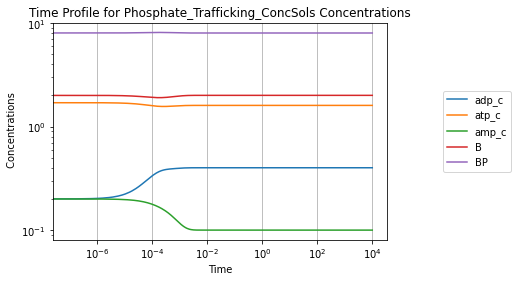

In [56]:
conc_sol.view_time_profile()

In [57]:
for k, v in conc_sol.items():
    print(k, v[-1])

adp_c 0.40000000000149216
atp_c 1.600000000005999
amp_c 0.10000000000037108
B 1.9999999999999587
BP 8.000000000000046


### Aggregate variables and solutions

Often, it is desirable to look at mathematical combinations of metabolites concentrations or reaction fluxes. To create an aggregate variable, the `MassSolution.make_aggregate_solution()` method is used. To use the method, three inputs are required:

1. A unique ID for the aggregate variable.
2. The mathematical equation for the aggregate variable given as a `str`.
3. A list of the `MassSolution` keys representing variables used in the equation.

For example, to make the Adenylate Energy Charge <cite data-cite="Atk68">(Atkinson, 1968)</cite>, the occupancy and capacity pools are first defined:

In [58]:
occupancy = conc_sol.make_aggregate_solution(
    aggregate_id="occupancy",
    equation="(atp_c + 0.5 * adp_c)",
    variables=["atp_c", "adp_c"])
conc_sol.update(occupancy)
print(list(conc_sol.keys()))

['adp_c', 'atp_c', 'amp_c', 'B', 'BP', 'occupancy']


The aggregate variables are returned as a `dict`, which can be added to the `MassSolution` object. Alternatively, the `update` flag can be set as `True` to automatically add an aggregate variable to the solution after creation.

In [59]:
capacity = conc_sol.make_aggregate_solution(
    aggregate_id="capacity",
    equation="(atp_c + adp_c + amp_c)",
    variables=["atp_c", "adp_c", "amp_c"], 
    update=True)
print(list(conc_sol.keys()))

['adp_c', 'atp_c', 'amp_c', 'B', 'BP', 'occupancy', 'capacity']


Aggregate variables formed from other aggregate variables also can be created using the `make_aggregate_solution()` method as long as the aggregate variables have been added to the `MassSolution`. To make the energy charge from the occupancy and capacity aggregate variables:

In [60]:
ec = conc_sol.make_aggregate_solution(
    aggregate_id="energy_charge",
    equation="occupancy / capacity",
    variables=["occupancy", "capacity"],
    update=True)

If care is taken when assigning aggregate variable identifiers, it is possible to access aggregate variable solutions inside of a `MassSolution`, as if aggregate variable keys were attributes.

In [61]:
# Print first 10 solution points for the energy charge
conc_sol.energy_charge[:10]

array([0.85714286, 0.85710645, 0.8570701 , 0.85697226, 0.85687471,
       0.85677749, 0.85668059, 0.85647669, 0.85604374, 0.85561747])

## Determining Steady State
The steady state for models can be found using the `Simulation.find_steady_state()` method. This method requires a model identifier or a `MassModel` object and a string thats indicates a strategy for finding the steady state. For example, to find the steady state by simulating the model for a long time:

In [62]:
sim = Simulation(reference_model=model)

conc_sol, flux_sol = sim.find_steady_state(model, strategy="simulate")
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

adp_c: 0.3999999999999983
atp_c: 1.5999999999999932
amp_c: 0.09999999999999959
B: 1.999999999999997
BP: 7.999999999999988


Setting `update_values=True` updates the model initial conditions and fluxes with the steady state solution:

In [63]:
conc_sol, flux_sol = sim.find_steady_state(model, strategy="simulate",
                                           update_values=True)
model.initial_conditions  # Same object as reference model in Simulation

{<MassMetabolite adp_c at 0x7fc278a0bb20>: 0.3999999999999983,
 <MassMetabolite atp_c at 0x7fc278a0bb80>: 1.5999999999999932,
 <MassMetabolite amp_c at 0x7fc278a0bbb0>: 0.09999999999999959,
 <MassMetabolite B at 0x7fc2dad5ed00>: 1.999999999999997,
 <MassMetabolite BP at 0x7fc2dad5efa0>: 7.999999999999988}

The `find_steady_state()` method also allows for perturbations to be made before determining a steady state solution:

In [64]:
conc_sol, flux_sol = sim.find_steady_state(
    model, strategy="simulate", perturbations={"kf_use": "kf_use * 1.5"})

for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

adp_c: 0.2666666666666716
atp_c: 0.7111111111111246
amp_c: 0.10000000000000185
B: 2.7272727272727235
BP: 7.272727272727263


## Perturbing a Model

To simulate various disturbances in the system, the `perturbations` argument of the `simulate()` method can be used. There are several types of perturbations that can be implemented for a given simulation as long as they adhere to the following guidelines:

1. Perturbations are provided to the method as a `dict` with dictionary keys that correspond to variables to be changed. Dictionary values are the new numerical values or mathematical expressions as strings that indicate how the value is to be changed.

2. A formula for the perturbation can be provided as a `str` as long as the formula string can be sympified via the `sympy.sympify()` function. The formula can have one variable that is identical to the corresponding `dict` key.

3. Boundary conditions can be set as a function of time. The above rules still apply, but allow for the time "t", as a second variable.

Some examples are demonstrated below.

A simulation without perturbations:

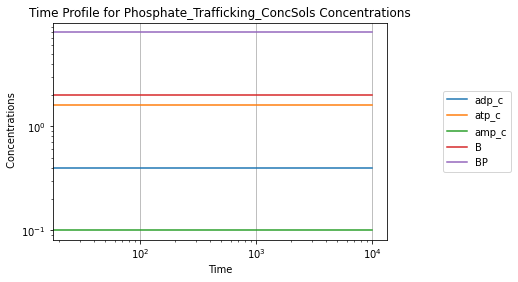

In [65]:
conc_sol, flux_sol = sim.simulate(model, time=(0, tfinal))
conc_sol.view_time_profile()

Perturbing the initial concentration of ATP from 1.6 to 2.5:

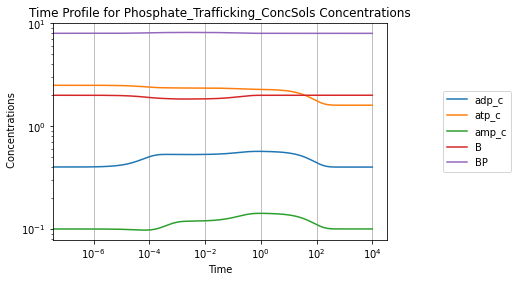

In [66]:
conc_sol, flux_sol = sim.simulate(
    model, time=(0, tfinal), perturbations={"atp_c": 2.5})
conc_sol.view_time_profile()

Increasing the rate constant of ATP use by 50%:

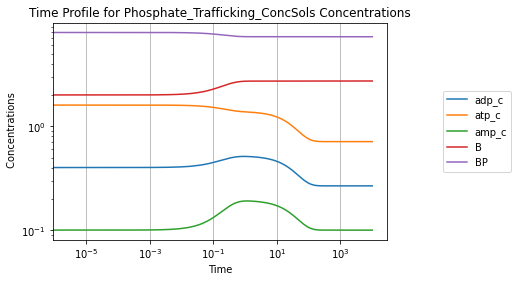

In [67]:
conc_sol, flux_sol = sim.simulate(
    model, time=(0, tfinal), perturbations={"kf_use": "kf_use * 1.5"})
conc_sol.view_time_profile()